In [1]:
%matplotlib inline

import numpy as np
import scipy.signal as sig
import scipy.stats as stat
import matplotlib.pyplot as plt
import seaborn as sns
import os
import h5py
import pandas as pd

from pandas import DataFrame,Series,read_table

In [2]:
## To run just one bird:

birdToRun = "Bird 3"
birdToRunID = int(birdToRun[5]) - 1

General info

In [3]:
savePlots = True    # whether or not to save plots
saveData = True # whether or not to save csv files

saveAsPath = './Fig 07/'
if not os.path.exists(saveAsPath):
    os.mkdir(saveAsPath)
saveAsName = 'Fig7'

In [4]:
#path = '/Users/svcanavan/Dropbox/Coding in progress/00_BudgieSleep/Data_copies/'

birdPaths =    ['../data_copies/01_PreprocessedData/01_BudgieFemale_green1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/02_BudgieMale_yellow1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/03_BudgieFemale_white1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/04_BudgieMale_yellow2/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/05_BudgieFemale_green2/00_Baseline_night/']

arfFilePaths =  ['EEG 2 scored/',
                 'EEG 3 scored/',
                 'EEG 3 scored/',
                 'EEG 4 scored/',
                 'EEG 4 scored/']

### load BEST EEG channels - as determined during manual scoring ####
channelsToLoadEEG_best = [['5 LEEGf-LEEGp', '6 LEEGm-LEEGp'],
                     ['5 LEEGf-LEEGm', '4 LEEGf-Fgr'],
                     ['4LEEGf-LEEGp', '9REEGm-REEGp'],
                     ['9REEGf-REEGp', '6LEEGm-LEEGf'],
                     ['4LEEGf-LEEGp','7REEGf-REEGp']]


### load ALL of EEG channels ####
channelsToLoadEEG = [['1 LEOG-Fgr', '2 REOG-Fgr', '4 LEEGf-Fgr', '5 LEEGf-LEEGp', '6 LEEGm-LEEGp', '7 LEEGp-Fgr', '8 REEGp-Fgr','9 REEGp-LEEGp'],
                     ['2 LEOG-Fgr', '3 REOG-Fgr', '4 LEEGf-Fgr','5 LEEGf-LEEGm', '6 LEEGm-LEEGp', '7 REEGf-Fgr', '8 REEGm-Fgr', '9 REEGf-REEGm'],
                     ['2LEOG-Fgr', '3REOG-Fgr', '4LEEGf-LEEGp', '5LEEGf-LEEGm', '6LEEGm-LEEGp', '7REEGf-REEGp', '8REEGf-REEGm', '9REEGm-REEGp'],
                     ['2LEOG-Fgr', '3REOG-Fgr', '4LEEGf-LEEGp', '5LEEGm-LEEGp', '6LEEGm-LEEGf', '7REEGf-Fgr', '8REEGf-REEGm','9REEGf-REEGp',],
                     ['2LEOG-Fgr', '3REOG-Fgr', '4LEEGf-LEEGp', '5LEEGf-LEEGm', '6LEEGm-LEEGp', '7REEGf-REEGp', '8REEGf-REEGm', '9REEGm-REEGp']]

channelsToLoadEOG = [['1 LEOG-Fgr', '2 REOG-Fgr'],
                     ['2 LEOG-Fgr', '3 REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr']]

birds_LL = [1,2,3]
nBirds_LL = len(birds_LL)

birdPaths_LL = ['../data_copies/01_PreprocessedData/02_BudgieMale_yellow1/01_Constant_light/',
                '../data_copies/01_PreprocessedData/03_BudgieFemale_white1/01_Constant_light/',
                '../data_copies/01_PreprocessedData/04_BudgieMale_yellow2/01_Constant_light/',]

arfFilePaths_LL =  ['EEG 2 preprocessed/',
                    'EEG 2 preprocessed/',
                    'EEG 2 preprocessed/']

lightsOffSec = np.array([7947, 9675, 9861 + 8*3600, 9873, 13467])  # lights off times in seconds from beginning of file
lightsOnSec = np.array([46449, 48168, 48375+ 8*3600, 48381, 52005]) # Bird 3 gets 8 hours added b/c file starts at 8:00 instead of 16:00

epochLength = 3
sr = 200
scalingFactor = (2**15)*0.195       # scaling/conversion factor from amplitude to uV (when recording arf from jrecord)

stages = ['w','d','u','i','s','r'] # wake, drowsy, unihem sleep, intermediate sleep, SWS, REM
stagesSleep =    ['u','i','s','r']

stagesVideo = ['m','q','d', 'l', 'r', 's','u'] # moving wake, quiet wake, drowsy, left uni, right uni, sleep, unclear

## Path to scores formatted as CSVs
formatted_scores_path = '../formatted_scores/'

## Path to detect SW ands EM events
events_path = '../data_copies/SWs_and_EMs/'

 ##### TEST DATA - THIS NOTEBOOK ONLY ######
    
birdPaths = ['','','/Users/Sofija/Dropbox/Coding in progress/00_BudgieSleep/data_copies/']
arfFilePaths = ['','','EEG/']

saveAsPath = '/Users/Sofija/Desktop/'

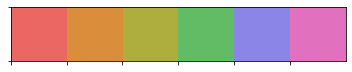

In [5]:
colors = sns.color_palette(np.array([[234,103,99],
[218,142,60],
[174,174,62],
[97,188,101],
[140,133,232],
[225,113,190]])
/255)

sns.palplot(colors)

# colorpalette from iWantHue

Plot-specific info

In [6]:
sns.set_context("notebook", font_scale=1)
sns.set_style("white")

# Markers for legends of EEG scoring colors
legendMarkersEEG = []
for stage in range(len(stages)):
    legendMarkersEEG.append(plt.Line2D([0],[0], color=colors[stage], marker='o', linestyle='', alpha=0.7))  

Calculate general variables

In [7]:
lightsOffEp = lightsOffSec / epochLength
lightsOnEp = lightsOnSec / epochLength

nBirds = len(birdPaths)

epochLengthPts = epochLength*sr

nStages = len(stagesSleep)

birds = np.arange(1,6)

## Read in files

Read in EEG traces

In [8]:
## To only load 1 bird: ##

b = birdToRunID
arf_path = birdPaths[b] + arfFilePaths[b]

EEGdataAll = {}
    
for channel in channelsToLoadEEG[b]:
    all_data_array = np.array([])

    for file in np.sort(os.listdir(arf_path)):
        if file.endswith('.arf'):
            arffile = h5py.File(arf_path+file, 'r')
            data_array = arffile['.'][channel].value
            data_array = np.ndarray.flatten(data_array)

            # Pad the end with NaN's to make it divisible by epoch length
            nanPadding = np.zeros(epochLengthPts - np.mod(len(data_array), epochLengthPts))
            nanPadding.fill(np.nan)
            data_array = np.append(data_array,nanPadding)   

            all_data_array = np.append(all_data_array,data_array)

    # Do not reshape

    # Save in dict under bird number and channel
    data_name = 'Bird ' + str(b+1) + ': ' + channel
    EEGdataAll[data_name] = scalingFactor * all_data_array
    

EEGchannels = np.sort(list(EEGdataAll.keys()))

/Users/svcanavan/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [9]:
# Create time index for EEG

all_time_array = np.array([], dtype='datetime64')
for file in np.sort(os.listdir(arf_path)):
    if file.endswith('.arf'):
        arffile = h5py.File(arf_path+file, 'r')

        date = file.split('_')[2]
        
        if b == 0:
            hours = '17'
            minutes = '32'
        else:
            time = file.split('_')[3]
            hours = time.split('-')[0]
            minutes = time.split('-')[1]
            
        datetime_start = np.datetime64(date + 'T' + hours + ':' + minutes + ':06')    # assume 6-s delay in starting recording

        # time index in datetime format
        length_s = len(arffile['.'][channel].value)/sr
        length_ms = np.timedelta64(int(1000 * length_s), 'ms')
        datetime_end = datetime_start + length_ms

        time_array = np.arange(datetime_start, datetime_end, np.timedelta64(int(1000/sr),'ms')) 

        # Add to end of whole-night time index
        all_time_array = np.append(all_time_array, time_array)
        
TimeIndexEEG = {}
data_name = 'Bird ' + str(b+1)
TimeIndexEEG[data_name] = all_time_array

# Load scores from CSV

In [10]:
AllScores = {}
for b in birds:
    # Load from file
    scores_file = 'All_scores_Bird {}.csv'.format(b)
    tmp_scores = pd.read_table(formatted_scores_path + scores_file, sep=',', index_col=0)
    
    # save to dict
    AllScores['Bird ' + str(b)] = tmp_scores   

# for each channel, mark as artifact epochs w/ data that crosses an amplitude threshold

In [11]:
# Set thresholds
artifact_threshold_uV = 2000
artifact_threshold_SD  = 8   # of SDs away from mean

# Make a scores array for each channel so it has independent artifact removal
ChannelScores = {}

for ch in EEGchannels:
    data = EEGdataAll[ch]
    artifact_threshold_SD_uV = np.abs(data[~np.isnan(data)]).mean() + artifact_threshold_SD*np.abs(data[~np.isnan(data)]).std()
    print(ch + ' : ' + str(artifact_threshold_SD_uV))
        
    b_name = ch[0:6]
    bird_scores = AllScores[b_name]['Label (#)'].values   # get scores as an array of numbers
    nEpochs = len(bird_scores)

    for ep in range(nEpochs):
        start_pts = ep * epochLengthPts
        stop_pts  = (ep+1) * epochLengthPts
        
        ep_data = data[start_pts:stop_pts]
        
        if any(np.abs(ep_data) > artifact_threshold_SD_uV):
            bird_scores[ep] = -2
            
    # Save to dataframe
    ChannelScores[ch] = bird_scores

Bird 3: 2LEOG-Fgr : 951.8403454208595


/Users/svcanavan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


Bird 3: 3REOG-Fgr : 1327.6657313150547
Bird 3: 4LEEGf-LEEGp : 842.5058855616585
Bird 3: 5LEEGf-LEEGm : 1128.986194419556
Bird 3: 6LEEGm-LEEGp : 846.5029175191506
Bird 3: 7REEGf-REEGp : 1278.7122134167391
Bird 3: 8REEGf-REEGm : 1225.5734246115394
Bird 3: 9REEGm-REEGp : 1085.989156418616


## Calculate lights off in Zeitgeber time (s and hrs)
Lights on is 0 

In [12]:
lightsOffZeit_s = lightsOffSec - lightsOnSec
lightsOffZeit_hr = lightsOffZeit_s / 3600

## Detect slow waves: define function

In [13]:
def detectSlowWaves(rawdata, data_scores, freqLowCut=0.5, freqHighCut=4, pos_or_neg_waves='neg', halfwaveAmpCrit_uV=75/2,
               halfwaveArtifactCrit_uV=600/2, peak_within_halfwaveAmpCrit_uV=300/2, artifact_pts=np.array([])):


    # if detecting positive waves, flip data before continuing with analysis
    if 'pos' in pos_or_neg_waves:
        rawdata = -rawdata

    # Calculate wavelength criteria for half-waves
    halfwaveMinLength = (1/freqHighCut)*sr/2
    halfwaveMaxLength = (1/freqLowCut)*sr/2

    # Calculate resolution & Nyquist frequency
    res = 1/sr
    fN = sr/2

    # Filter data in delta range

    filtOrder = 2
    filtB, filtA = sig.butter(filtOrder, [freqLowCut/fN, freqHighCut/fN], 'bandpass', output='ba')
    data = sig.filtfilt(filtB, filtA, rawdata)

    # Find upwards and downwards zero-crossings

    zeroCrossingsDown = np.where(np.diff(np.sign(data)) < 0)[0]
    zeroCrossingsUp   = np.where(np.diff(np.sign(data)) > 0)[0]

    # To select for only negative half waves, remove first UZC if it is earlier than DZC
    if zeroCrossingsUp[0] < zeroCrossingsDown[0]:
        zeroCrossingsUp = zeroCrossingsUp[1::]

    # If last DZC doesn't have a corresponding UZC following it, remove
    if zeroCrossingsDown[-1] > zeroCrossingsUp[-1]:
        zeroCrossingsDown = zeroCrossingsDown[0:-1]

    # Get wavelengths, keep those in sleep epochs & within delta frequency
    halfwaveLengths = zeroCrossingsUp - zeroCrossingsDown

    # Too short
    BadZC = np.where(halfwaveLengths < halfwaveMinLength)[0]
    # Too long
    BadZC = np.append(BadZC, np.where(halfwaveLengths > halfwaveMaxLength)[0])

    # Remove bad DZC/UZC pairs
    BadZC = np.sort(np.unique(BadZC))

    DZC = np.delete(zeroCrossingsDown,BadZC)
    UZC = np.delete(zeroCrossingsUp,  BadZC)

    # e. Loop through each wave, test for criteria

    # Initialize
    swCount = 0
    swStartInds = []
    swPeakInds = []
    swStopInds   = []
    swPeakAmps = []
    swNegSlopes = []
    swPosSlopes = []
    swLengths  = []
    swFreqs    = []


    for n in range(len(DZC)):
        half_waveform = data[DZC[n]:UZC[n]]

        # Not within sleep epochs
        
        data_scores_starts_pts = (data_scores['Time (s)'] - start)*sr
        data_scores_stops_pts  = (data_scores['Time (s)'] + epochLength - start)*sr

        epochs_spanned = data_scores.loc[(DZC[n]<=data_scores_stops_pts.values) & (UZC[n]>=data_scores_starts_pts.values)]
        if any(epochs_spanned['Label (#)'] < 2):
            isSlowWave = False
        else:
            
        # Test for overlap with pre defined list of artifact points
        
            overlap_thres = .5    # threshold for proportion of wave that can overlap artifact

            start_pts = DZC[n]
            stop_pts   = UZC[n]
            length_pts = stop_pts - start_pts
            wave_range_pts = np.arange(start_pts, stop_pts)

            # repeat_counts: the number of times an index appears in both the slow wave and artifacts ranges
            unique, repeat_counts = np.unique(np.append(wave_range_pts, artifact_pts), return_counts=True)

            overlap_pts = sum(repeat_counts > 1)   # count overlapping points
            if overlap_pts >=overlap_thres*length_pts:   # compare to length of slow wave
                isSlowWave = False
            else:
                    
            # Test amplitude peak: larger than amplitude criteria, smaller than artifact threshold
                peakAmp = np.abs(np.min(half_waveform ))
                if (peakAmp>=halfwaveAmpCrit_uV) & (peakAmp<halfwaveArtifactCrit_uV):

                    # Get the negative & positive slopes
                    minNegSlope = np.min(np.diff(half_waveform )/res)
                    maxPosSlope = np.max(np.diff(half_waveform )/res)

                    # Get amplitude of local upward peaks within the half wave
                    peaks_within_halfwave_ind = sig.argrelmax(half_waveform)

                    if len(peaks_within_halfwave_ind) > 0:
                        peaks_within_halfwave_amp = half_waveform[peaks_within_halfwave_ind]
                        if any(peaks_within_halfwave_amp >= -peak_within_halfwaveAmpCrit_uV):
                            isSlowWave = False
                        else:
                            isSlowWave = True
                    else:
                        isSlowWave = True

                    if isSlowWave:
                        # It's a slow wave - add characteristics to arrays
                        swCount = swCount + 1
                        swStartInds.append(DZC[n])
                        swPeakInds.append(DZC[n] + np.argmin(half_waveform))
                        swStopInds.append(UZC[n])
                        swPeakAmps.append(peakAmp)
                        swNegSlopes.append(minNegSlope)
                        swPosSlopes.append(maxPosSlope)
                        swLengths.append((UZC[n] - DZC[n])/sr)
                        swFreqs.append((1/((UZC[n] - DZC[n])/sr))/2)

    swStart_s = start + np.array(swStartInds)/sr
    swStop_s = start + np.array(swStopInds)/sr

    # if had been detecting positive waves, flip the sign of data, amplitudes
    if 'pos' in pos_or_neg_waves:
        swPeakAmps = list(np.array(swPeakAmps))
        data = -data
        rawdata = -rawdata
    else:
        halfwaveAmpCrit_uV = -halfwaveAmpCrit_uV
        halfwaveArtifactCrit_uV = -halfwaveArtifactCrit_uV
        peak_within_halfwaveAmpCrit_uV = -peak_within_halfwaveAmpCrit_uV
        
    waves_detected = {'data':data,'zeroCrossingsDown':zeroCrossingsDown,'zeroCrossingsUp':zeroCrossingsUp,'DZC':DZC,'UZC':UZC,
                      'swCount':swCount,'swStartInds':swStartInds,'swPeakInds':swPeakInds,'swStopInds':swStopInds,
                      'swPeakAmps':swPeakAmps,'swNegSlopes':swNegSlopes,'swPosSlopes':swPosSlopes, 'swLengths':swLengths,
                      'swFreqs':swFreqs,'swStart_s':swStart_s,'swStop_s':swStop_s}
        
    return(waves_detected)

## Detect eye movements in EOG: define function

In [14]:
def detectEyeMovements(rawdata, data_scores, freqLowCut=0.2, freqHighCut=60, pos_or_neg_waves='neg', halfwaveAmpCrit_uV=5000,
               halfwaveArtifactCrit_uV=500000, negSlopeThres=75):

    # if detecting positive waves, flip data before continuing with analysis
    if 'pos' in pos_or_neg_waves:
        rawdata = -rawdata

    # Calculate wavelength criteria for half-waves
    halfwaveMinLength = (1/freqHighCut)*sr/2
    halfwaveMaxLength = (1/freqLowCut)*sr/2

    # Calculate resolution & Nyquist frequency
    res = 1/sr
    fN = sr/2

    # No filtering

    #filtOrder = 2
    #filtB, filtA = sig.butter(filtOrder, [freqLowCut/fN, freqHighCut/fN], 'bandpass', output='ba')
    #data = sig.filtfilt(filtB, filtA, rawdata)
    data = rawdata

    # Find upwards and downwards zero-crossings

    zeroCrossingsDown = np.where(np.diff(np.sign(data)) < 0)[0]
    zeroCrossingsUp   = np.where(np.diff(np.sign(data)) > 0)[0]

    # To select for only negative half waves, remove first UZC if it is earlier than DZC
    if zeroCrossingsUp[0] < zeroCrossingsDown[0]:
        zeroCrossingsUp = zeroCrossingsUp[1::]

    # If last DZC doesn't have a corresponding UZC following it, remove
    if zeroCrossingsDown[-1] > zeroCrossingsUp[-1]:
        zeroCrossingsDown = zeroCrossingsDown[0:-1]

    # Get wavelengths, keep those in sleep epochs & within delta frequency
    halfwaveLengths = zeroCrossingsUp - zeroCrossingsDown

    # Too short
    BadZC = np.where(halfwaveLengths < halfwaveMinLength)[0]
    # Too long
    BadZC = np.append(BadZC, np.where(halfwaveLengths > halfwaveMaxLength)[0])

    # Remove bad DZC/UZC pairs
    BadZC = np.sort(np.unique(BadZC))

    DZC = np.delete(zeroCrossingsDown,BadZC)
    UZC = np.delete(zeroCrossingsUp,  BadZC)

    # e. Loop through each wave, test for criteria

    # Initialize
    swCount = 0
    swStartInds = []
    swPeakInds = []
    swStopInds   = []
    swPeakAmps = []
    swNegSlopes = []
    swPosSlopes = []
    swLengths  = []
    swFreqs    = []


    for n in range(len(DZC)):
        half_waveform = data[DZC[n]:UZC[n]]

        # Not within sleep epochs
        data_scores_starts_pts = (data_scores['Time (s)'] - start)*sr
        data_scores_stops_pts  = (data_scores['Time (s)'] + epochLength - start)*sr

        epochs_spanned = data_scores.loc[(DZC[n]<=data_scores_stops_pts.values) & (UZC[n]>=data_scores_starts_pts.values)]
        if any(epochs_spanned['Label (#)'] < 2):
            isSlowWave = False
        else:

            # Test amplitude peak: larger than amplitude criteria, smaller than artifact threshold

            peakAmp = np.abs(np.min(half_waveform ))
            if (peakAmp>=halfwaveAmpCrit_uV) & (peakAmp<halfwaveArtifactCrit_uV):

                # Get the negative & positive slopes
                minNegSlope = np.min(np.diff(half_waveform )/res)
                maxPosSlope = np.max(np.diff(half_waveform )/res)
                
                # Test if the fastest negative slope
                if minNegSlope > -negSlopeThres:
                    isSlowWave = False
                else:
                    isSlowWave = True


                if isSlowWave:
                    # It's a slow wave - add characteristics to arrays
                    swCount = swCount + 1
                    swStartInds.append(DZC[n])
                    swPeakInds.append(DZC[n] + np.argmin(half_waveform))
                    swStopInds.append(UZC[n])
                    swPeakAmps.append(peakAmp)
                    swNegSlopes.append(minNegSlope)
                    swPosSlopes.append(maxPosSlope)
                    swLengths.append((UZC[n] - DZC[n])/sr)
                    swFreqs.append((1/((UZC[n] - DZC[n])/sr))/2)

    swStart_s = start + np.array(swStartInds)/sr
    swStop_s = start + np.array(swStopInds)/sr

    # if had been detecting positive waves, flip the sign of data, amplitudes
    if 'pos' in pos_or_neg_waves:
        swPeakAmps = list(-np.array(swPeakAmps))
        data = -data
        rawdata = -rawdata
    else:
        halfwaveAmpCrit_uV = -halfwaveAmpCrit_uV
        halfwaveArtifactCrit_uV = -halfwaveArtifactCrit_uV
        
    waves_detected = {'data':data,'zeroCrossingsDown':zeroCrossingsDown,'zeroCrossingsUp':zeroCrossingsUp,'DZC':DZC,'UZC':UZC,
                      'swCount':swCount,'swStartInds':swStartInds,'swPeakInds':swPeakInds,'swStopInds':swStopInds,
                      'swPeakAmps':swPeakAmps,'swNegSlopes':swNegSlopes,'swPosSlopes':swPosSlopes, 'swLengths':swLengths,
                      'swFreqs':swFreqs,'swStart_s':swStart_s,'swStop_s':swStop_s}
        
    return(waves_detected)

## Define function to plot manual scores

In [15]:
def PlotScoresBar(b, startTime, dT=20, scoreBarWidth=10, sr=sr, colors=colors, stages=stages):

    '''Plot Figure 1: sleep score, EEG & EOG
    b = bird name
    startTime = where to start plotting, in seconds
    dT = number of seconds to plot
    ylimAmtEOG / EEG = set range of y axis above & below 0
    yCalibBarEOG / EEG = how big to make the calibration bar for uV
    xCalibBarEOG / EEG = how big to make the calibration bar for sec
    
    sr = sampling rate
    colors = list of colors to use for plotting sleep stages
    stages = list of sleep/wake stages
    EOGchannels = dictionary of EOG channels to use (for all birds)
    EEGchannels = dictionary of EEG channels to use (for all birds)

    '''

    # Bird number from 0-4:
    birdID = int(b[5])-1
    
    # Get datetime index
    time_index = TimeIndexEEG[b]
    start_datetime_rec = time_index[0]
    
    # calc start and stop datetimes
    start_timedelta = np.timedelta64(startTime, 's')
    dt_timedelta = np.timedelta64(dT, 's')
    
    start_datetime = start_datetime_rec + start_timedelta
    stop_datetime = start_datetime + dt_timedelta
    
    dP = dT*sr
    
    offset = 0/15    # fraction of plot size to leave blank on either side

    ###########################################################################

    # Plotting parameters
    width = scoreBarWidth
    scoreLoc = 0

    # Get scores to plot
    scoresToPlot = AllScores[b][str(start_datetime).replace('T', ' '):str(stop_datetime).replace('T', ' ')]['Label'].values
    start_sec = pd.to_datetime(start_datetime).second
    firstEpOffset = (start_sec%epochLength)*sr # how much of first epoch is cut off at beginning, in pts
    nEpochs = len(scoresToPlot)
    
    # replace 'l' or 'g' in "Scores to Plot" with 'u' for unihem
    unihem_inds = [x for x in range(nEpochs) if ('l' in scoresToPlot[x])|('g' in scoresToPlot[x])]
    scoresToPlot[unihem_inds] = 'u'

    # 1. Plot first epoch (which might be cut off at beginning):

     # determine color based on sleep stage
    scoreNum = [x for x in range(len(stages)) if stages[x] in scoresToPlot[0]][0]
    scoreColor = colors[scoreNum]
     # determine where to draw the bar
    start = 0
    stop  = epochLengthPts - firstEpOffset
     # draw the bar
    plt.hlines(scoreLoc, start, stop, color=scoreColor, linewidth=width)

    # 2. Plot middle epochs
    for ep in np.arange(1,nEpochs-1):
         # determine color based on sleep stage
        scoreNum = [x for x in range(len(stages)) if stages[x] in scoresToPlot[ep]][0]
        scoreColor = colors[scoreNum]
         # determine where to draw the bar
        start = ep*epochLengthPts - firstEpOffset
        stop  = ep*epochLengthPts - firstEpOffset + epochLengthPts
         # draw the bar
        plt.hlines(scoreLoc, start, stop, color=scoreColor, linewidth=width)

    # 3. Plot last epoch (which might be cut off at end)
    lastEp = nEpochs-1
     # determine color based on sleep stage
    scoreNum = [x for x in range(len(stages)) if stages[x] in scoresToPlot[lastEp]][0]
    scoreColor = colors[scoreNum]
     # determine where to draw the bar
    start = lastEp*epochLengthPts - firstEpOffset
    stop  = dP
     # draw the bar
    plt.hlines(scoreLoc, start, stop, color=scoreColor, linewidth=width)

    # Get rid of axes
    plt.yticks([])
    plt.xticks([])
    sns.despine(left=True, bottom=True)

    plt.xlim(plt.xlim(-dP*offset, dP + dP*offset))

# Run on data

## Pick data

In [16]:
b = birdToRunID
bird_time = TimeIndexEEG[birdToRun]

In [18]:
# Pick start and stop times
start = (13*3600) + (45*60) 
end = start + (5*60)
dT = end - start
start_pts = start*sr
end_pts = end*sr

freqLowCut=0.5
freqHighCut=4
fN=sr/2

# Get sleep scores
scores = AllScores[birdToRun]
data_scores = scores[(scores['Time (s)']>=start) & (scores['Time (s)']<=end)]

## Detect eye movements

In [19]:
EOGchannels = [x for x in EEGchannels if 'EOG' in x]
data_LEOG = EEGdataAll[EOGchannels[0]][start_pts:end_pts]
data_REOG = EEGdataAll[EOGchannels[1]][start_pts:end_pts]


EOG_product = data_LEOG * data_REOG

rems_detected = detectEyeMovements(EOG_product, data_scores, pos_or_neg_waves='neg')

# Plot

In [20]:
chToPlot = EEGchannels[4]

In [21]:
figsize = (9,10)
axis_label_fontsize = 24

# EEG plot formatting
linewidth = 1
linealpha = 1
color = [0,0,0]
eog_color = [.7, .7, .7]
product_color = [.3, .3, .3]
dzc_color = colors[4]
uzc_color = (0.4490196078431373, 0.42156862745098043, 0.80980392156862744)
em_color = colors[5]
artifact_color = colors[0]

### FIGURE 07A: Plot eye movements

In [22]:
chToPlot=EEGchannels[4]
xlim_min = 50
xlim_max = xlim_min+15

([], <a list of 0 Text yticklabel objects>)

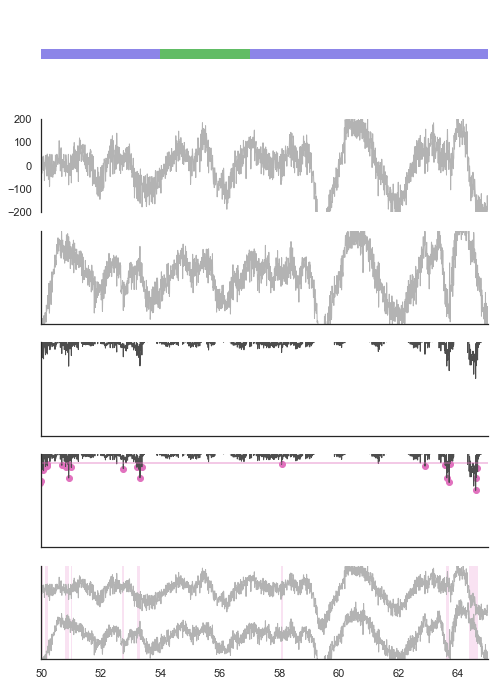

In [23]:
nPlots = 6

plt.figure(figsize=(8,2*nPlots))
time = np.arange(0,dT,1/sr)

row=1
plt.subplot(nPlots, 1, row)
PlotScoresBar(birdToRun, start+xlim_min, dT=xlim_max-xlim_min)
row += 1

for ch in EOGchannels:
    plt.subplot(nPlots, 1, row)

    rawdata = EEGdataAll[ch][start_pts:end_pts]
    plt.plot(time,rawdata, lw=linewidth, alpha=linealpha, color=eog_color)
    
    #plt.ylabel(ch[9::])

    plt.xlim(xlim_min,xlim_max)
    plt.ylim(-200,200)

    plt.xticks([])

    if row==2:
        ax1=plt.gca()
        sns.despine(bottom=True, ax=ax1)
    else:
        ax2=plt.gca()
        sns.despine(bottom=False, ax=ax2)
        plt.yticks([])

        
    row+=1

plt.subplot(nPlots, 1, row)
plt.plot(time, EOG_product, lw=linewidth, alpha=linealpha, color=product_color)
ax3=plt.gca()
sns.despine(ax=ax3)
plt.xlim(xlim_min,xlim_max)
plt.ylim(-60000,1000)
plt.yticks([])
plt.xticks([])
#plt.ylabel('EOG product')
row+=1

plt.subplot(nPlots, 1, row)
plt.plot(time, EOG_product, lw=linewidth, alpha=linealpha, color=product_color)
plt.axhline(-5000, color=em_color, alpha=linealpha/2)

# scatterplot of peaks: if peaks exceed y axis, plot dot on edge of plot
peaks = -1*np.array(rems_detected['swPeakAmps'])
peaks[peaks<=-60000] = -59900
plt.scatter(np.array(rems_detected['swPeakInds'])/sr, peaks, color=em_color)
ax4=plt.gca()
sns.despine(ax=ax4)
plt.xlim(xlim_min,xlim_max)
plt.ylim(-60000,1000)
plt.yticks([])
plt.xticks([])
#plt.ylabel('EOG product')
row+=1

plt.subplot(nPlots, 1, row)
plt.hlines(y=np.repeat(0.5, rems_detected['swCount']), xmin=rems_detected['swStart_s']-start, xmax=rems_detected['swStop_s']-start, linewidth=1000,alpha=.2, color=em_color)
offset = 0
for ch in EOGchannels:
    rawdata = EEGdataAll[ch][start_pts:end_pts]
    plt.plot(time, rawdata + offset*400, lw=linewidth, alpha=linealpha, color=eog_color)
    offset-=1
ax5=plt.gca()
sns.despine(ax=ax5)
plt.xlim(xlim_min,xlim_max)
plt.ylim(10+offset*300, 200)
plt.yticks([])

#plt.ylabel('eye movements')
        
#if savePlots:
    #plt.savefig(saveAsPath + saveAsName + birdToRun + str(start) + 's_em_detection.pdf')
    #plt.savefig(saveAsPath + saveAsName + 'a_' + birdToRun + str(start) + 's_em_detection.tiff', dpi=300)

## Detect eye movement artifacts

In [24]:
Artifacts_EM_pos = {}
Artifacts_EM_neg = {}
ampCrit_artifacts = 10000

for ch in EEGchannels:
    if 'EEG' in ch:
        if 'LEEG' in ch:
            eog_ch = EOGchannels[0]
        elif 'REEG' in ch:
            eog_ch = EOGchannels[1]
            
        data_EEG = EEGdataAll[ch][start*sr:end*sr]
        data_EOG = EEGdataAll[eog_ch][start*sr:end*sr]
        EEG_EOG_product = data_EEG * data_EOG  # Take product of EEG channel x ipsilateral EOG
        
        artifacts_detected = detectEyeMovements(EEG_EOG_product, data_scores, pos_or_neg_waves='pos',halfwaveAmpCrit_uV=ampCrit_artifacts,
               halfwaveArtifactCrit_uV=ampCrit_artifacts*10000, negSlopeThres=10)
        Artifacts_EM_pos[ch] = artifacts_detected
        artifacts_detected = detectEyeMovements(EEG_EOG_product, data_scores, pos_or_neg_waves='neg',halfwaveAmpCrit_uV=ampCrit_artifacts,
               halfwaveArtifactCrit_uV=ampCrit_artifacts*10000, negSlopeThres=10)
        Artifacts_EM_neg[ch] = artifacts_detected

### Define list of points encompassed by artifacts

In [25]:
All_Artifacts_points = {}

for ch in EEGchannels:
    if 'EEG' in ch:
        artifact_points_ch = np.array([])   # init

        # Pos artifacts
        artifacts = Artifacts_EM_pos[ch]

        for artifact in range(artifacts['swCount']):
            start_pts = artifacts['swStartInds'][artifact]
            stop_pts  = artifacts['swStopInds'][artifact]
            range_pts = np.arange(start_pts, stop_pts)
            artifact_points_ch = np.append(artifact_points_ch, range_pts)

        # Neg artifacts
        artifacts = Artifacts_EM_neg[ch]

        for artifact in range(artifacts['swCount']):
            start_pts = artifacts['swStartInds'][artifact]
            stop_pts  = artifacts['swStopInds'][artifact]
            range_pts = np.arange(start_pts, stop_pts)
            artifact_points_ch = np.append(artifact_points_ch, range_pts)

        All_Artifacts_points[ch] = artifact_points_ch

## Detect slow waves, excluding eye movement artifacts

In [26]:
All_Waves_neg = {}
All_Waves_pos = {}

for ch in EEGchannels:
    if 'EEG' in ch:
        rawdata = EEGdataAll[ch][start*sr:end*sr]
        waves_detected_neg = detectSlowWaves(rawdata,
                          data_scores, artifact_pts=All_Artifacts_points[ch],
                          pos_or_neg_waves='neg')
        waves_detected_pos = detectSlowWaves(rawdata,
                          data_scores, artifact_pts=All_Artifacts_points[ch],
                          pos_or_neg_waves='pos')
    
        All_Waves_neg[ch] = waves_detected_neg
        All_Waves_pos[ch] = waves_detected_pos

### FIGURE 07D: Plot slow wave detection

#### used Bird 3 for this particular figure in the paper? This is a different example from the same bird

In [27]:
chToPlot=EEGchannels[4]
xlim_min = 45 
xlim_max = xlim_min+15

dT = end - start
start_pts = start*sr
end_pts = end*sr


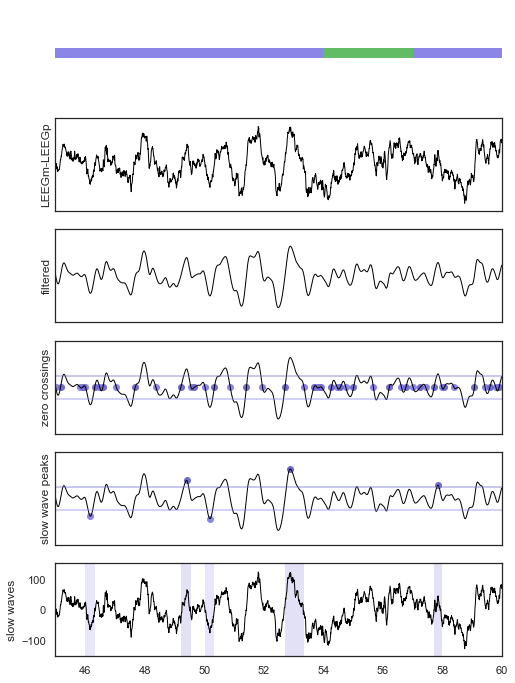

In [28]:
nPlots = 7

plt.figure(figsize=(8,2*nPlots))
time = np.arange(0,dT,1/sr)

# Scores bar
row=1
plt.subplot(nPlots, 1, row)
PlotScoresBar(birdToRun, start+xlim_min, dT=xlim_max-xlim_min)
row += 1

# Pick channel
ch = chToPlot
neg_waves = All_Waves_neg[ch]
pos_waves = All_Waves_pos[ch]

# raw data
plt.subplot(nPlots, 1, row)
rawdata = EEGdataAll[ch][start_pts:end_pts]
plt.plot(time, rawdata, lw=linewidth, alpha=linealpha, color=color)
plt.ylabel(ch[9::])
plt.xlim(xlim_min,xlim_max)
plt.ylim(-150,150)
plt.yticks([])
plt.xticks([])
row+=1

# filtered data
plt.subplot(nPlots, 1, row)
filtOrder = 2
filtB, filtA = sig.butter(filtOrder, [freqLowCut/fN, freqHighCut/fN], 'bandpass', output='ba')
filt_data = sig.filtfilt(filtB, filtA, rawdata)

plt.plot(time, filt_data, lw=linewidth, alpha=linealpha, color=color)
plt.ylabel('filtered')
plt.xlim(xlim_min,xlim_max)
plt.ylim(-150,150)
plt.yticks([])
plt.xticks([])
row+=1

# filtered, initial UZC and DZC
plt.subplot(nPlots, 1, row)
zeroCrossingsDown = np.where(np.diff(np.sign(filt_data)) < 0)[0]
zeroCrossingsUp   = np.where(np.diff(np.sign(filt_data)) > 0)[0]
plt.plot(time, filt_data, lw=linewidth, alpha=linealpha, color=color)
plt.scatter(zeroCrossingsDown/sr, np.zeros_like(zeroCrossingsDown), color=dzc_color)
plt.scatter(zeroCrossingsUp/sr, np.zeros_like(zeroCrossingsUp), color=uzc_color)
# thresholds
plt.axhline(-75/2, alpha=linealpha/2, color=dzc_color)
plt.axhline(75/2, alpha=linealpha/2, color=uzc_color)
plt.ylabel('zero crossings')
plt.xlim(xlim_min,xlim_max)
plt.ylim(-150,150)
plt.yticks([])
plt.xticks([])
row+=1

# final amp peaks
plt.subplot(nPlots, 1, row)
plt.plot(time, filt_data, lw=linewidth, alpha=linealpha, color=color)
plt.scatter(np.array(neg_waves['swPeakInds'])/sr, -1*np.array(neg_waves['swPeakAmps']), color=dzc_color)
plt.scatter(np.array(pos_waves['swPeakInds'])/sr, np.array(pos_waves['swPeakAmps']), color=uzc_color)
# thresholds
plt.axhline(-75/2, alpha=linealpha/2, color=dzc_color)
plt.axhline(75/2, alpha=linealpha/2, color=uzc_color)
plt.ylabel('slow wave peaks')
plt.xlim(xlim_min,xlim_max)
plt.ylim(-150,150)
plt.yticks([])
plt.xticks([])
row+=1

# slow waves detected
plt.subplot(nPlots, 1, row)

plt.hlines(y=np.repeat(0.5, neg_waves['swCount']), xmin=neg_waves['swStart_s']-start, xmax=neg_waves['swStop_s']-start,linewidth=140,alpha=.2, color=dzc_color)
plt.hlines(y=np.repeat(0.5, pos_waves['swCount']), xmin=pos_waves['swStart_s']-start, xmax=pos_waves['swStop_s']-start,linewidth=140,alpha=.2, color=uzc_color)        
plt.plot(time,rawdata, lw=linewidth, alpha=linealpha, color=color)

plt.ylabel('slow waves')
plt.xlim(xlim_min,xlim_max)
plt.ylim(-150,150)
row+=1

if savePlots:
    #plt.savefig(saveAsPath + saveAsName + birdToRun + '_' + ch[0:9] + str(start) + 's_sw_detection.pdf')
    plt.savefig(saveAsPath + saveAsName + 'd_' + birdToRun + '_' + ch[0:9] + str(start) + 's_sw_detection.tiff', dpi=300)

### Plot eye movement artifacts

/Users/svcanavan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


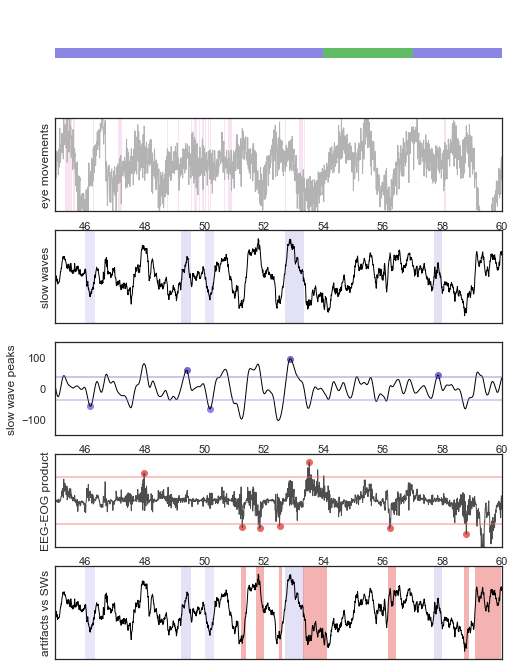

In [29]:
nPlots = 6

plt.figure(figsize=(8,2*nPlots))
time = np.arange(0,dT,1/sr)

# Pick channel
ch = chToPlot
neg_waves = All_Waves_neg[ch]
pos_waves = All_Waves_pos[ch]

row=1
plt.subplot(nPlots, 1, row)
PlotScoresBar(birdToRun, start+xlim_min, dT=xlim_max-xlim_min)
row += 1

# plot EOGs
plt.subplot(nPlots, 1, row)
plt.hlines(y=np.repeat(0.5, rems_detected['swCount']), xmin=rems_detected['swStart_s']-start, xmax=rems_detected['swStop_s']-start, linewidth=130,alpha=.2, color=em_color)
offset = 0
if 'LEEG' in ch:
    eog_ch = EOGchannels[0]
elif 'REEG' in ch:
    eog_ch = EOGchannels[1]
    
rawdata = EEGdataAll[eog_ch][start*sr:end*sr]
plt.plot(time, rawdata, lw=linewidth, alpha=linealpha, color=eog_color)
plt.xlim(xlim_min,xlim_max)
plt.ylim(-150,150)
plt.ylabel('eye movements')
plt.yticks([]);
row+=1

# plot EEG channel
plt.subplot(nPlots, 1, row)
rawdata = EEGdataAll[ch][start*sr:end*sr]
plt.hlines(y=np.repeat(0.5, neg_waves['swCount']), xmin=neg_waves['swStart_s']-start, xmax=neg_waves['swStop_s']-start,linewidth=140,alpha=.2, color=dzc_color)
plt.hlines(y=np.repeat(0.5, pos_waves['swCount']), xmin=pos_waves['swStart_s']-start, xmax=pos_waves['swStop_s']-start,linewidth=140,alpha=.2, color=uzc_color)        
plt.plot(time,rawdata, lw=linewidth, alpha=linealpha, color=color)
plt.ylabel('slow waves')
plt.yticks([])
plt.xticks([])
plt.xlim(xlim_min,xlim_max)
plt.ylim(-150,150)
row+=1

plt.subplot(nPlots, 1, row)
plt.plot(time, filt_data, lw=linewidth, alpha=linealpha, color=color)
plt.scatter(np.array(neg_waves['swPeakInds'])/sr, -1*np.array(neg_waves['swPeakAmps']), color=dzc_color)
plt.scatter(np.array(pos_waves['swPeakInds'])/sr, np.array(pos_waves['swPeakAmps']), color=uzc_color)
# thresholds
plt.axhline(-75/2, alpha=linealpha/2, color=dzc_color)
plt.axhline(75/2, alpha=linealpha/2, color=uzc_color)
plt.ylabel('slow wave peaks')
plt.xlim(xlim_min,xlim_max)
plt.ylim(-150,150)
row+=1

# Ipsilateral EOG
plt.subplot(nPlots, 1, row)
if 'LEEG' in ch:
    eog_ch = EOGchannels[0]
elif 'REEG' in ch:
    eog_ch = EOGchannels[1]
data_EOG = EEGdataAll[eog_ch][start*sr:end*sr]
# Product of EEG x ipsEOG
plt.subplot(nPlots, 1, row)
plt.plot(time, rawdata*data_EOG, lw=linewidth, alpha=linealpha, color=product_color)
# thresholds
plt.axhline(-ampCrit_artifacts, color=artifact_color, alpha=linealpha/2)
plt.axhline(ampCrit_artifacts, color=artifact_color, alpha=linealpha/2)
# artifact peaks
neg_artifacts = Artifacts_EM_neg[ch]
pos_artifacts = Artifacts_EM_pos[ch]
plt.scatter(np.array(neg_artifacts['swPeakInds'])/sr, -1*np.array(neg_artifacts['swPeakAmps']), color=artifact_color)
plt.scatter(np.array(pos_artifacts['swPeakInds'])/sr, -1*np.array(pos_artifacts['swPeakAmps']), color=artifact_color)
plt.xlim(xlim_min,xlim_max)
plt.ylim(-20000,20000)
plt.yticks([])
plt.ylabel('EEG-EOG product')
row+=1

# EEG with slow waves & artifacts
plt.subplot(nPlots, 1, row)
rawdata = EEGdataAll[ch][start*sr:end*sr]
plt.hlines(y=np.repeat(0.5, neg_waves['swCount']), xmin=neg_waves['swStart_s']-start, xmax=neg_waves['swStop_s']-start,linewidth=140,alpha=.2, color=dzc_color)
plt.hlines(y=np.repeat(0.5, pos_waves['swCount']), xmin=pos_waves['swStart_s']-start, xmax=pos_waves['swStop_s']-start,linewidth=140,alpha=.2, color=uzc_color)        
plt.hlines(y=np.repeat(0.5, neg_artifacts['swCount']), xmin=neg_artifacts['swStart_s']-start, xmax=neg_artifacts['swStop_s']-start,linewidth=140,alpha=.5, color=artifact_color)
plt.hlines(y=np.repeat(0.5, pos_artifacts['swCount']), xmin=pos_artifacts['swStart_s']-start, xmax=pos_artifacts['swStop_s']-start,linewidth=140,alpha=.5, color=artifact_color)        
plt.plot(time,rawdata, lw=linewidth, alpha=linealpha, color=color)
plt.ylabel('artifacts vs SWs')
plt.yticks([])
plt.xticks([])
plt.xlim(xlim_min,xlim_max)
plt.ylim(-150,150)
row+=1

#if savePlots:
    #plt.savefig(saveAsPath + saveAsName + birdToRun + str(start) + 's_artifact_detection.pdf')
    #plt.savefig(saveAsPath + saveAsName + birdToRun + str(start) + 's_artifact_detection.tiff', dpi=300)

## Plot slow waves in all channels

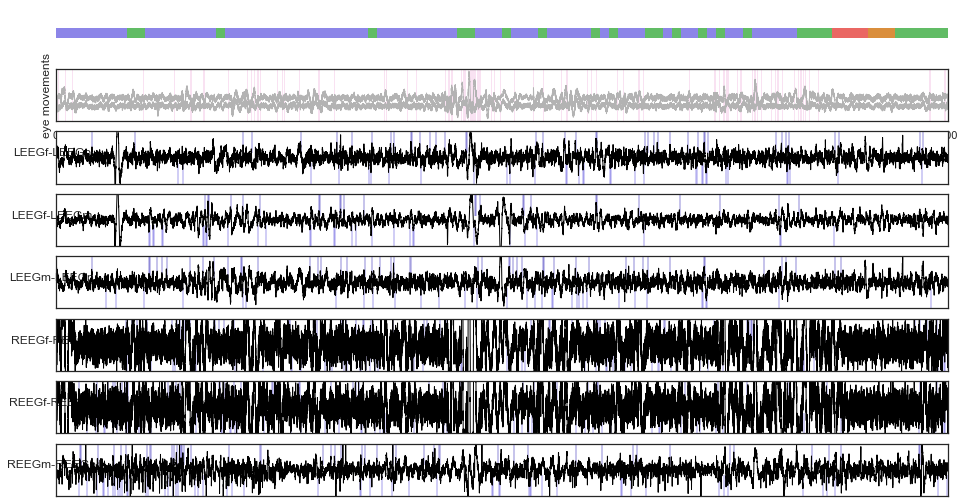

In [30]:
nPlots = len(EEGchannels)

plt.figure(figsize=(16,1*nPlots+1))
time = np.arange(0,dT,1/sr)

row=1
plt.subplot(nPlots, 1, row)
PlotScoresBar(birdToRun,start,dT)
row+=1

# plot EOGs
plt.subplot(nPlots, 1, row)
plt.hlines(y=np.repeat(0.5, rems_detected['swCount']), xmin=rems_detected['swStart_s']-start, xmax=rems_detected['swStop_s']-start, linewidth=130,alpha=.2, color=em_color)
offset = 0
for eog_ch in EOGchannels:
    rawdata = EEGdataAll[eog_ch][start*sr:end*sr]
    plt.plot(time, rawdata + offset*300, lw=linewidth, alpha=linealpha, color=eog_color)
    offset+=1
plt.xlim(0,dT)
#plt.ylim(-150,150)
plt.ylabel('eye movements')
plt.yticks([]);
row+=1

for ch in EEGchannels:
    if 'EEG' in ch:
        plt.subplot(nPlots, 1, row)
        rawdata = EEGdataAll[ch][start*sr:end*sr]
        plt.plot(time,rawdata, lw=linewidth, alpha=linealpha, color=color)
        
        neg_waves = All_Waves_neg[ch]
        plt.hlines(y=np.repeat(-100, neg_waves['swCount']), xmin=neg_waves['swStart_s']-start, xmax=neg_waves['swStop_s']-start,linewidth=25,color=dzc_color,alpha=.8)
        pos_waves = All_Waves_pos[ch]
        plt.hlines(y=np.repeat(100, pos_waves['swCount']), xmin=pos_waves['swStart_s']-start, xmax=pos_waves['swStop_s']-start,linewidth=25,color=uzc_color,alpha=.8)        
        plt.ylabel(ch[9::],rotation=0)
        plt.yticks([])
        plt.xticks([])
        plt.ylim(-150,150)
        plt.xlim(0, dT)
        row+=1
        
#if savePlots:
    #plt.savefig(saveAsPath + saveAsName + birdToRun + str(start) + 's_detected_waves.pdf')
    #plt.savefig(saveAsPath + saveAsName + birdToRun + str(start) + 's_detected_waves.tiff')